# TSP Lecture - HA Models

Jamie Lenney 

Dec 2025 


## Objectives

* Motivate incomplete markets 

* Understand how income risk and borrowing constraints underpin HA model mechanisms

* Know how to solve a HA

* Examine the properties of a Hugget model

**Further reading** - Ljungqvist and Sargent Recursive Macroeconmic Theroy chapters: 17,18 

%jupyter nbconvert notebook.ipynb --to slides --SlidesExporter.reveal_theme=sky


## Incomplete Markets 

What is this? 

* Can think of a representative agent model as a model where individuals have written contracts to hedge against all risk
    * They are still exposed to aggregate risk
    * Can still have complete markets models with wealth distribution but all agents consumption would move proportinally in the same way. 

* When this is not possible we have incomplete markets
    * e.g. There are not sufficient assets/contracts to trade. 

* Incomplete markets creates incentives for self-insurance
    * Saving for a 'rainy day'




## Consumption Savings Problem

Households maximize lifetime expected utility:

$$\max_{\{c_t, a_{t+1}\}_{t=0}^{\infty}} \mathbb{E}_0 \sum_{t=0}^{\infty} \beta^t u(c_t)$$

where:
- $c_t$ = consumption at time $t$
- $\beta \in (0,1)$ = discount factor
- $u(c)$ = instantaneous utility function (typically CRRA)



### Constraints

#### Budget Constraint
$$c_t + a_{t+1} = (1+r)a_t + y_t$$

- $a_t$ = assets at beginning of period $t$
- $r$ = interest rate
- $y_t$ = labor income (stochastic)

#### Borrowing Constraint
$$a_{t+1} \geq \underline{a}$$

- $\underline{a}$ = borrowing limit
- Common cases: $\underline{a} = 0$ (no borrowing) or $\underline{a} < 0$ (some debt allowed)

### Income Process

#### Stochastic Income
Labor income follows a Markov process:

$$\log y_t = \rho \log y_{t-1} + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma^2)$$

Can be discretized into:
- $y_t \in \{y_1, y_2, ..., y_N\}$ (finite states)
- Transition matrix $\Pi$ where $\Pi_{ij} = \Pr(y_{t+1} = y_j | y_t = y_i)$

**Key feature**: Households face **uninsurable idiosyncratic risk**
- Cannot fully smooth consumption
- Need to self-insure through savings



### Bellman Equation

#### Recursive Formulation
$$V(a, y) = \max_{a' \geq \underline{a}} \left\{ u(c) + \beta \mathbb{E}[V(a', y') | y] \right\}$$

subject to:
$$c = (1+r)a + y - a'$$

where:
- $V(a,y)$ = value of having assets $a$ and income $y$ today
- $a'$ = assets tomorrow (choice variable)
- $\mathbb{E}[V(a', y') | y] = \sum_{y'} \Pi(y'|y) V(a', y')$

- **State variables**: $(a, y)$
  - $a$ = current assets (continuous)
  - $y$ = current income (discrete)

- **Choice variables**: $(c)$


### First Order Conditions

#### Lagrangian
$$\mathcal{L} = u(c_t) + \beta \mathbb{E}_t[V_{t+1}(a_{t+1})] + \lambda_t(a_{t+1} - \underline{a})$$

#### FOC with respect to $a_{t+1}$
$$u'(c_t) = \beta (1+r) \mathbb{E}_t[u'(c_{t+1})] + \lambda_t$$

#### Complementary Slackness
- $\lambda_t \geq 0$
- $a_{t+1} - \underline{a} \geq 0$
- $\lambda_t (a_{t+1} - \underline{a}) = 0$

---

### Two Cases

#### Case 1: Interior Solution ($a_{t+1} > \underline{a}$)

**Constraint not binding**: $\lambda_t = 0$

$$u'(c_t) = \beta (1+r) \mathbb{E}_t[u'(c_{t+1})]$$

This is the **Euler equation**: standard intertemporal optimality condition

**Interpretation**: Marginal cost of saving = marginal benefit of saving

---

## Two Cases (cont.)

##### Case 2: Constrained ($a_{t+1} = \underline{a}$)

**Constraint binding**: $\lambda_t > 0$

$$u'(c_t) = \beta (1+r) \mathbb{E}_t[u'(c_{t+1})] + \lambda_t$$

Therefore:
$$u'(c_t) > \beta (1+r) \mathbb{E}_t[u'(c_{t+1})]$$

**Interpretation**: 
- Household would like to borrow more but cannot
- Marginal utility today exceeds discounted expected marginal utility tomorrow
- Consuming "too little" today relative to unconstrained optimum


## Value Function Iteration (VFI)

- Goal: solve household problem by iterating on the Bellman equation directly to find the value function and policy functions.

- Core idea
  - For each state (productivity z, assets a), maximize over all possible asset choices a' to find the value function.
  - Bellman equation: V(z,a) = max_{a'} { u(c) + β E[V(z',a') | z] }
  - Subject to: c = (1+r)a + wz - a' and c ≥ 0, a' ≥ a_min

- Algorithm (one backward step)
  1. For each (z, a) state, construct value for each possible a' choice on grid
  2. Compute consumption: c = cash-on-hand - a'
  3. Calculate value: V = u(c) + β E[V_{t+1}(z', a')]
  4. Find optimal choice: a* = argmax_{a'} V
  5. Store V(z,a) = max V and policy a(z,a) = a*

- Advantages
  - Simple and robust; works with any utility function
  - No need for invertible Euler equation
  - Can handle non-convexities, occasionally binding constraints

- Limitations / notes
  - Computationally expensive: O(nZ × nA²) per iteration
  - Policy functions can be jagged/non-smooth with coarse grids
  - Requires fine grids (nA = 2000+) for smooth policies
  - Much slower than EGM for standard models

In [8]:
cali={} # calibration

# household 
cali['beta']=0.98 # patience
cali['sigma']=2 # risk aversion
cali['eis']=1/cali['sigma'] # intertemporal elasticity of substitution
cali['bc']=-0.2
cali['borwedge']=0.0

cali['rho_z']=0.97
cali['sd_z']=0.6

# aggregate economy
cali['r']=0.04/4
cali['w']=1.0
cali['govT']=0

# discretization
cali['nA']=500
cali['nZ']=5
cali['amax']=125


In [38]:
def household_vfit_init( r, coh, eis): # initial guess for marginal value function
    V = (0.1 * coh)**(1-1/eis)/(1-1/eis)  # utility level
    return V

@het(exogenous='Pi', policy='a', backward='V', backward_init=household_vfit_init)
def household_vfit(V_p, a_grid, r, coh, beta, eis,nZ):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    V_p     : array (nE, nA), expected  value function next period
    a_grid   : array (nA), asset grid
    z_grid   : array (nE), producticity grid
    r        : scalar, ex-post real interest rate
    w        : scalar, wage
    beta     : scalar, discount factor
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    V : array (nE, nA), value function today
    a  : array (nE, nA), asset policy today
    c  : array (nE, nA), consumption policy today
    """

    c=coh[:,:,np.newaxis]-a_grid[np.newaxis,np.newaxis,:]
    Vupdate=c**(1-1/eis)/(1-1/eis)+beta*V_p[:,np.newaxis,:]
    Vupdate[c<=0]=-1e10
    v_choice = np.argmax(Vupdate, axis=2)
    
    V = np.take_along_axis(Vupdate, v_choice[:, :, np.newaxis], axis=2).squeeze(axis=2)
    a = a_grid[v_choice]
    c = coh - a
    
    return V,a,c


hh_vfit=household_vfit.add_hetinputs([make_grid,income])

cali_vfit=copy.deepcopy(cali)
cali_vfit['nA']=2500
ss0_vfit=hh_vfit.steady_state(cali_vfit)

c_vfit=ss0_vfit.internals['household_vfit']['c']
D_vfit=ss0_vfit.internals['household_vfit']['D']

from matplotlib import pyplot as plt
a_grid_vfit=ss0_vfit.internals['household_vfit']['a_grid']

D_vfit=ss0_vfit.internals['household_vfit']['D']


In [17]:
import numpy as np
from sequence_jacobian import het, interpolate, misc, grids,utilities
import copy
## Household problem

def make_grid(bc, amax, nA,nZ,rho_z,sd_z):
    
    z_grid, pi_z, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sd_z, N=nZ)  
    a_grid = utilities.discretize.nonlinspace(amax,nA ,1.2, amin = bc) # normalized grid between zero and one with n_a number of points
    
    return z_grid, pi_z, Pi, a_grid


def income(w,r,borwedge,a_grid,z_grid,govT):

    rexpand=r*np.ones_like(a_grid) 
    rexpand[a_grid<0]=r+borwedge
    coh = (1+rexpand)*a_grid + w*z_grid[:, np.newaxis]+govT

    return coh


def household_init( r, coh, eis): # initial guess for marginal value function
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    return Va


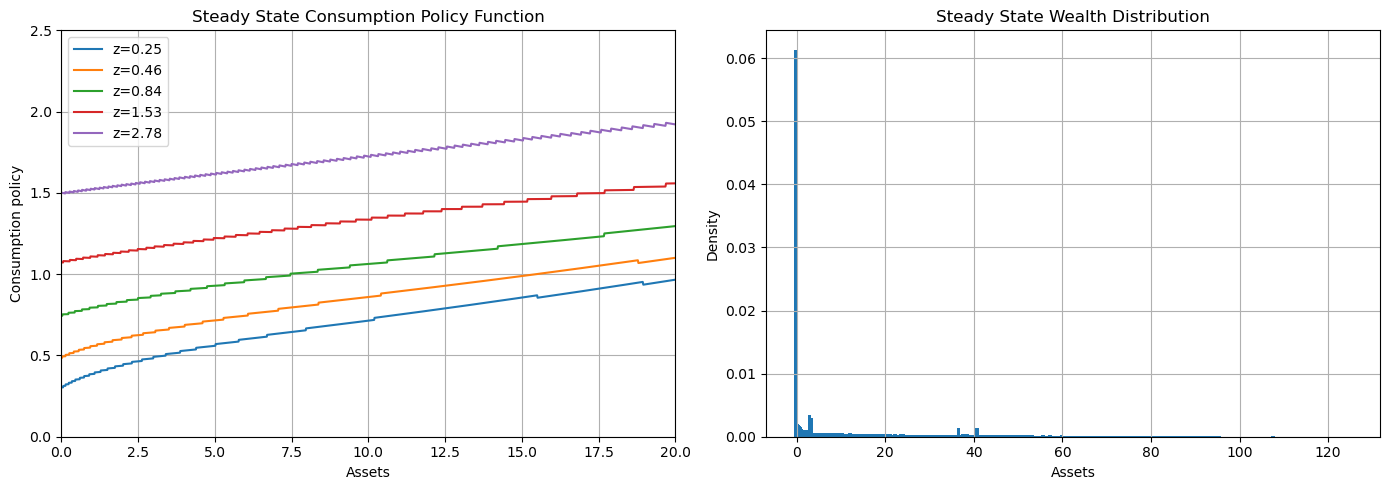

In [40]:
from numpy.polynomial import Polynomial


# Polynomial approximation to c_vfit for each z

poly_degree = 15
c_poly_fits = []

for i in range(cali_vfit['nZ']):
    p = Polynomial.fit(a_grid_vfit, c_vfit[i, :], poly_degree)
    c_poly_fits.append(p)

fig_vfit, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Consumption policy
for i, p in enumerate(c_poly_fits):
    #ax1.plot(a_grid_vfit, p(a_grid_vfit), label='z='+str(round(ss0_vfit.internals['household_vfit']['z_grid'][i],2)))
    ax1.plot(a_grid_vfit, c_vfit[i,:], label='z='+str(round(ss0_vfit.internals['household_vfit']['z_grid'][i],2)))

ax1.set_xlabel('Assets')
ax1.set_ylabel('Consumption policy')
ax1.set_title('Steady State Consumption Policy Function')
ax1.legend()
ax1.grid()
ax1.set_xlim(0,20)
ax1.set_ylim(0,2.5)

# Right panel: Savings policy
ax2.bar(a_grid_vfit, np.sum(D_vfit,axis=0))
ax2.set_xlabel('Assets')
ax2.set_ylabel('Density')
ax2.set_title('Steady State Wealth Distribution')
ax2.grid()

fig_vfit.tight_layout()


fig_vfit.savefig('steady_state_consumption_policy_vfit.png')

## Endogenous Gridpoint Method (EGM)

- Goal: solve household Euler equation without repeated root-finding at every asset grid point — faster and smoother than brute-force VFI.

- Core idea
  - Use Euler equation to compute optimal consumption on the *next-period* grid of assets (endogenous grid), then recover the implied current assets.
  - For CRRA utility: $u'(c) = c^{-\sigma}$. Euler gives
    $u'(c_t) = β(1+r) E[u'(c_{t+1})]$  ⇒  $c_t = [β(1+r) E[u'(c_{t+1})]]^{\frac{-1}{\sigma}}$

- Algorithm (one backward step)
  1. Compute expected marginal utility next period: m = β(1+r) E[u'(c_{t+1})].
  2. Invert marginal utility to get c_t at each next-period asset grid point: c_t = m^{\frac{-1}{\sigma}}.
  3. Compute implied current assets: $a_t = coh - c_t$  (coh = current cash-on-hand).
  4. Interpolate policy ($a_t$ → $c_t$) from the endogenous a_t back onto the exogenous asset grid.
  5. Enforce borrowing constraint: where implied $a_t$ < $\bar{a}$ set a = a_min and recompute $c = coh - a$.

- Advantages
  - No inner-loop maximization; vectorizable and much faster.
  - Produces smooth consumption/savings policies when monotonicity holds.

- Limitations / notes
  - Requires invertible Euler equation (works easily with CRRA).


In [ ]:
@het(exogenous='Pi', policy='a', backward='Va', backward_init=household_init)
def household(Va_p, a_grid, r, coh, beta, eis,nZ):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    Va_p     : array (nE, nA), expected marginal value of assets next period
    a_grid   : array (nA), asset grid
    z_grid   : array (nE), producticity grid
    r        : scalar, ex-post real interest rate
    w        : scalar, wage
    beta     : scalar, discount factor
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    Va : array (nE, nA), marginal value of assets today
    c  : array (nE, nA), consumption policy today
    a  : array (nE, nA), asset policy today
    """

    uc_nextgrid= beta * Va_p

    c_today = uc_nextgrid ** (-(eis))
    
    a = interpolate.interpolate_y(c_today + a_grid, coh, a_grid) # when i have coh(t)=c_today(t) + a_grid(t+1) i chose a_grid, what do i choose if on the coh grid today?
    misc.setmin(a, a_grid[0]) # apply borrowing constraint
    c = coh - a # work out consumptin policy today on the a_grid
    Va = (1 + r) * c ** (-1 / (eis)) #calculate marginal value today on the a_grid

    return Va, a, c

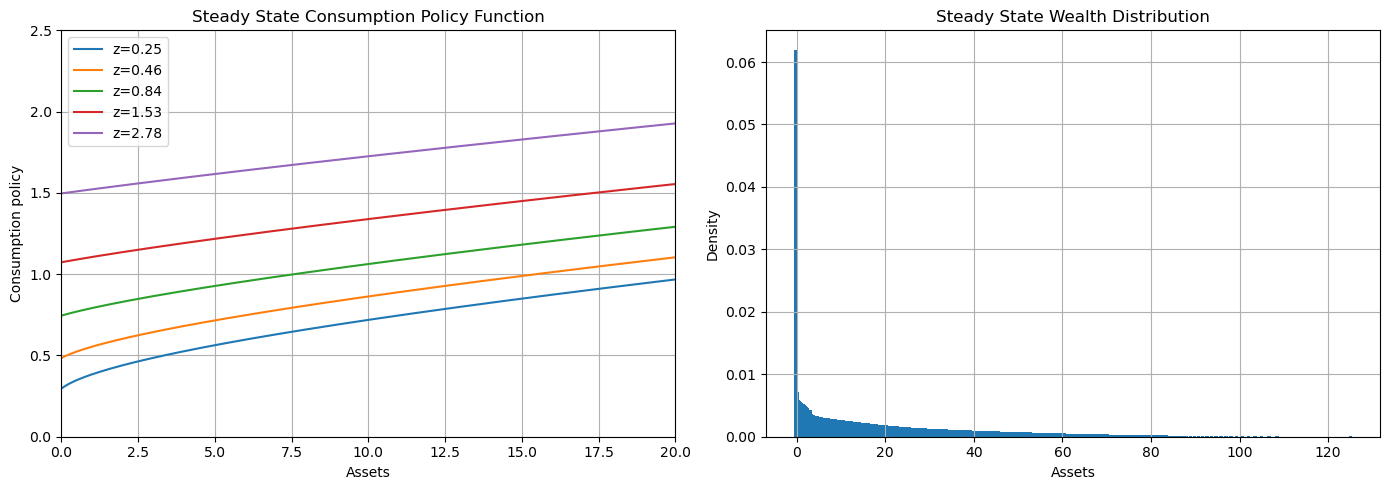

In [42]:


hh=household.add_hetinputs([make_grid,income])
ss0=hh.steady_state(cali)

from matplotlib import pyplot as plt
a_grid=ss0.internals['household']['a_grid']

D=ss0.internals['household']['D']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Consumption policy
ax1.plot(a_grid, ss0.internals['household']['c'][:,:].T)
ax1.set_xlabel('Assets')
ax1.set_ylabel('Consumption policy')
ax1.set_title('Steady State Consumption Policy Function')
ax1.legend(['z='+str(round(z,2)) for z in ss0.internals['household']['z_grid']])
ax1.grid()
ax1.set_xlim(0,20)
ax1.set_ylim(0,2.5)

# Right panel: Savings policy
ax2.bar(a_grid, np.sum(D,axis=0))
ax2.set_xlabel('Assets')
ax2.set_ylabel('Density')
ax2.set_title('Steady State Wealth Distribution')
ax2.grid()

fig.tight_layout()


fig.savefig('steady_state_consumption_policy.png')

### Consumption Functions

![Economic Model](steady_state_consumption_policy.png)




### Aggregate Savings

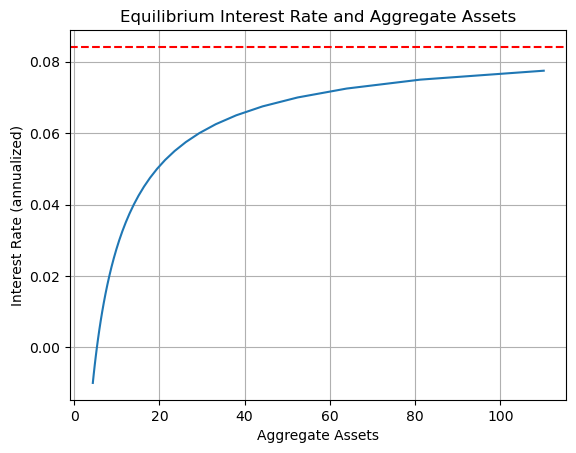

In [35]:
import copy 

r_grid=np.arange(-0.01,0.08,0.0025)/4
A_grid=np.zeros_like(r_grid)
ss_list=[]

cali_r=copy.deepcopy(cali)

for r in r_grid:
    cali_r['r']=r
    ss=hh.steady_state(cali_r)
    ss_list.append(ss)
    A_grid[np.where(r_grid==r)[0][0]]=ss['A']

plt.plot(A_grid,r_grid*4)
plt.ylabel('Interest Rate (annualized)')
plt.xlabel('Aggregate Assets')
plt.title('Equilibrium Interest Rate and Aggregate Assets')
plt.axhline(y=1/cali['beta']**4-1, color='r', linestyle='--', label='CM baseline')
plt.grid()

plt.savefig('equilibrium_interest_rate_vs_aggregate_assets.png')


![Aggregate Savings](equilibrium_interest_rate_vs_aggregate_assets.png)

